In [1]:
import os
import csv  
import pdb
from multiprocessing import Pool

import numpy as np
import pandas as pd
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
import scipy.ndimage
from scipy.stats import kstest

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import patches
from matplotlib.patches import Rectangle
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
#import celerite
import radvel

import rvsearch

import occur
from occur import Completeness, Hierarchy

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
sysprops = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('~/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
#objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
# Now including GL 876 small inner planet in the sample, in this repo's tables.
objects = pd.read_csv('legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [5]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

## Get diggity with some occurrence work.

In [6]:
def lngrid(min_a, max_a, min_M, max_M, resa, resm):
    lna1 = np.log(min_a)
    lna2 = np.log(max_a)
    lnM1 = np.log(min_M)
    lnM2 = np.log(max_M)
    
    dlna = (lna2 - lna1)/resa
    dlnM = (lnM2 - lnM1)/resm

    bins = []
    for i in np.arange(int(resa)):
        for j in np.arange(int(resm)):
            bins.append([[lna1 + i*dlna, lna1 + (i+1)*dlna], 
                         [lnM1 + j*dlnM, lnM1 + (j+1)*dlnM]])
            
    return np.array(bins)

In [7]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [8]:
samples_all = pd.read_csv('../legacy_samples/samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

# Trim out planets that don't belong in each sample.
#columns_outers = [col for col in samples_all.columns if col[:-2] in list(supers.hostname)]
#columns_small = [col for col in samples_all.columns if col[:-2] in list(all_outers.hostname)]
columns_good = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.02) and (samples_med[M_col] > 0.09):
        columns_good.append(a_col)
        columns_good.append(M_col)
        
samples_all = samples_all[columns_good]

for col in columns_good:
    if '_M' in col:
        samples_all[col] *= 317.8

In [9]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_one = Hierarchy(samples_all, completey_all, bins=allbins)
hierarchical_one.max_like()

In [68]:
hierarchical_one.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [45:39<00:00,  2.74s/it]


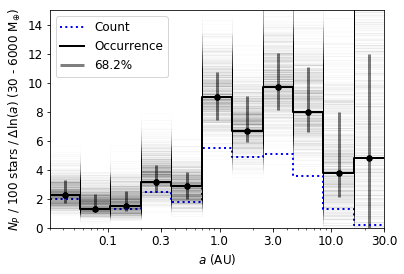

In [64]:
matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x1_1014.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(hierarchical_one.nbins):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_one.nbins):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_one.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_one.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_one.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)/binwidth
a_159 = np.array(a_159)/binwidth
a_841 = np.array(a_841)/binwidth
a_682 = np.array(a_682)/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_xlim([np.exp(hierarchical_one.lna_edges[0]), np.exp(hierarchical_one.lna_edges[-1])])
ax.set_ylim([0, 15])
lnaw = hierarchical_one.lna_edges[1] - hierarchical_one.lna_edges[0]

# Plot just-counting, no-completeness histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_one.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_one.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='black', lw=3, label='68.2%')
# Show CI from 0 to 68.2 for the last bin.
ax.vlines(np.exp(hierarchical_one.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Occurrence')

for i in np.arange(1000):
    ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
            np.insert(a_chains[:, np.random.randint(0, 10000)], 0, a_medians[0]), 
            color='black', lw=1, alpha=0.01, label='_nolegend_')
 
ax.legend(loc=2) 

#fig.savefig('hist_11x1_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
#fig.savefig('hist_11x1_1014_fancy_mode.pdf', bbox_inches='tight')

## Split sample into giant singles & multis, compare axis distributions.

In [7]:
recoveries_single = pd.read_csv('../recovery_files/recoveries_giant_single_earth.csv')
completey_single  = Completeness(recoveries_single)
completey_single.completeness_grid([0.01, 40], [2, 9000])

recoveries_multi = pd.read_csv('../recovery_files/recoveries_giant_multi_earth.csv')
completey_multi  = Completeness(recoveries_multi)
completey_multi.completeness_grid([0.01, 40], [2, 9000])

recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
completey_all.completeness_grid([0.01, 40], [2, 9000])

## Make sampling dataframes for single & multi subsets.

In [8]:
giants = planets.query('mass >= 0.1')
warmys = giants.query('axis >= 0.1 and axis < 0.66')
names = np.unique(giants.hostname)
wnames = np.unique(warmys.hostname)
trendnames = list(trends.hostname) + list(np.unique(planets_s.hostname))
trendnames.remove('156668')
trendnames.remove('34445')
singles = []
multis  = []
wsingles = []
wmultis  = []

for name in names:
    if len(giants.query('hostname == @name')) == 1:
        singles.append(name)
    else:
        multis.append(name)
        
for name in wnames:
    if len(giants.query('hostname == @name and axis >= 0.1')) == 1:
        wsingles.append(name)
    else:
        wmultis.append(name)
        
giants_single = giants.query('hostname in @singles')
giants_multi = giants.query('hostname in @multis')
warmys_single = giants.query('hostname in @wsingles')
warmys_multi = giants.query('hostname in @wmultis')


giants_single_trend = giants.query('hostname in @singles and not hostname in @trendnames')
giants_single_trend_yes = giants.query('hostname in @singles and hostname in @trendnames')
giants_multi_trend = giants.query('hostname in @multis or hostname in @trendnames')

warmys_single_trend = giants.query('hostname in @wsingles and not hostname in @trendnames')
warmys_multi_trend = giants.query('hostname in @wmultis or hostname in @trendnames')

singles_all = list(np.unique(giants_single_trend.hostname))
multis_all  = list(np.unique(giants_multi_trend.hostname))

In [9]:
giants_single_trend_yes

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
16,24,120136,K,1.0,4.298490,4.300469,4.225411,4.375587,0.048687,0.048691,...,0.010295,1367.422404,1366.903399,1277.162926,1461.387665,0.106361,0.106371,1277.162926,1461.387665,/data/user/lrosenth/legacy/final_run/120136/12...
19,31,126614,K,2.0,0.362820,0.355723,0.325338,0.387393,2.290922,2.291438,...,0.608016,0.274735,0.274536,0.253273,0.297712,0.893369,0.893531,0.253273,0.297712,/data/user/lrosenth/legacy/final_run/126614/12...
37,60,145934,K,1.0,2.069045,2.039347,1.809421,2.279885,4.723628,4.729761,...,0.082606,1.045723,1.043213,0.928609,1.179259,0.639595,0.639980,0.928609,1.179259,/data/user/lrosenth/legacy/final_run/145934/14...
73,123,195019,K,1.0,3.659636,3.655242,3.564412,3.744674,0.137595,0.137601,...,0.021344,125.096620,125.022174,114.479318,136.378507,0.193396,0.193425,114.479318,136.378507,/data/user/lrosenth/legacy/final_run/195019/19...
123,233,72659,K,1.0,2.822173,2.849142,2.733440,2.968966,4.645677,4.652452,...,0.278498,0.113990,0.113597,0.103829,0.124301,1.113122,1.114085,0.103829,0.124301,/data/user/lrosenth/legacy/final_run/72659/726...


### Look into warm giant companions.

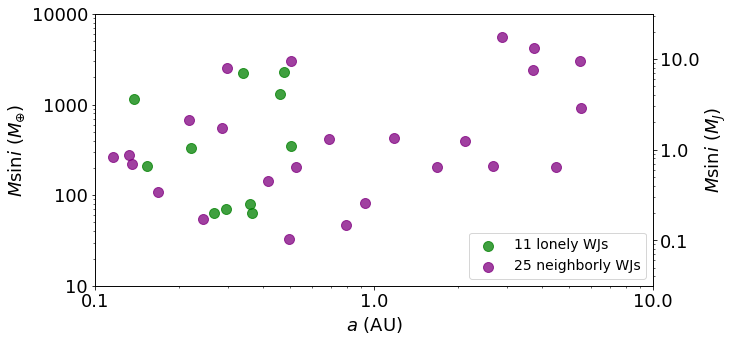

In [12]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.set_yticks((1, 10, 100, 1000, 10000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks((0.1, 1, 10, 100))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

matplotlib.rcParams.update({'font.size': 18})

ax.scatter(warmys_single.axis_med, 317.8*warmys_single.mass_med, c='g', s=100, alpha=0.75, 
           label='{} lonely WJs'.format(len(warmys_single)))
ax.scatter(warmys_multi.axis_med, 317.8*warmys_multi.mass_med, s=100, c='purple', alpha=0.75, 
           label='{} neighborly WJs'.format(len(warmys_multi)))
ax.set_xlim([0.1, 10])
ax.set_ylim([10, 10000])

ymin, ymax = ax.get_ylim()
ax2.set_ylim((ymin/317.8,ymax/317.8))
ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=4, fontsize=14)

fig.savefig('plots/m_a_scatter_warmies.pdf', bbox_inches='tight')

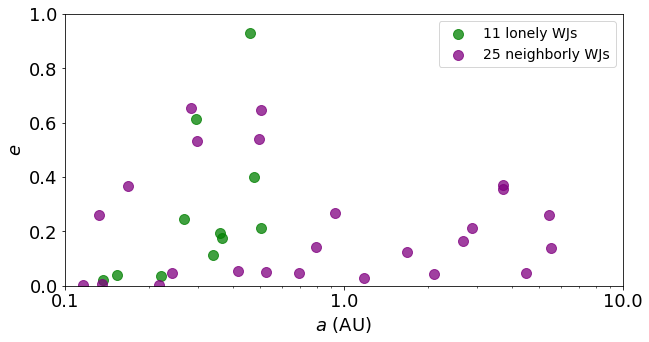

In [10]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

matplotlib.rcParams.update({'font.size': 18})

ax.scatter(warmys_single.axis_med, warmys_single.e_med, c='g', s=100, alpha=0.75, 
           label='{} lonely WJs'.format(len(warmys_single)))
ax.scatter(warmys_multi.axis_med, warmys_multi.e_med, s=100, c='purple', alpha=0.75, 
           label='{} neighborly WJs'.format(len(warmys_multi)))
ax.set_xlim([0.1, 10])
ax.set_ylim([0, 1])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$e$')
ax.legend(loc=1, fontsize=14)

fig.savefig('plots/e_a_scatter_warmies.pdf', bbox_inches='tight')

In [17]:
print(len(np.unique(warmys_single.hostname)), 'single warmies, ', len(np.unique(warmys_multi.hostname)), 'multi warmies')

11 single warmies,  10 multi warmies


In [10]:
print(len(giants_single), len(giants_single_trend))
print(len(giants_multi), len(giants_multi_trend))

65 60
69 74


In [12]:
list(set(giants.query('axis <= 0.1').hostname) & set(trendnames))

['187123', '120136']

In [34]:
giants_multi_trend.query('axis <= 0.06')

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
16,24,120136,K,1.0,4.298490,4.300469,4.225411,4.375587,0.048687,0.048691,...,0.010295,1367.422404,1366.903399,1277.162926,1461.387665,0.106361,0.106371,1277.162926,1461.387665,/data/user/lrosenth/legacy/final_run/120136/12...
65,107,187123,K,1.0,0.500667,0.500908,0.485032,0.516744,0.041856,0.041856,...,0.005883,755.117521,754.982881,691.684522,823.385235,0.123383,0.123389,691.684522,823.385235,/data/user/lrosenth/legacy/final_run/187123/18...
150,279,9826,K,1.0,0.674950,0.675053,0.659440,0.690768,0.059136,0.059137,...,0.010037,970.423046,970.110927,885.564317,1060.665474,0.115883,0.115892,885.564317,1060.665474,/data/user/lrosenth/legacy/final_run/9826/9826...


In [17]:
giants.query('axis <= 0.1').hostname

16        120136
22        130322
55        168746
62        179949
65        187123
68        189733
74        209458
78        217014
79        217107
110        46375
111        49674
118        68988
150         9826
167    bd-103166
172        83443
Name: hostname, dtype: object

In [14]:
list(list(set(giants_single.hostname)-set(giants_single_trend.hostname)) + list(set(giants_single_trend.hostname)-set(giants_single.hostname)))

['195019', '145934', '34445', '156668']

In [15]:
list(list(set(giants_multi.hostname)-set(giants_multi_trend.hostname)) + list(set(giants_multi_trend.hostname)-set(giants_multi.hostname)))

['195019', '145934', '34445', '156668']

In [12]:
samples_all = pd.read_csv('../legacy_samples/samples_all_joker.csv').sample(500).reset_index(drop=True)
samples_med = samples_all.median()

columns = [col for col in samples_all.columns if ('_M' in col or '_a' in col)]
samples_all = samples_all[columns]
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

columns_single = []
columns_multi  = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[M_col] > 0.08) and planet[:-2] in singles:#singles_all:
        columns_single.append(a_col)
        columns_single.append(M_col)
    elif (samples_med[M_col] > 0.08) and planet[:-2] in multis: #multis_all:
        columns_multi.append(a_col)
        columns_multi.append(M_col)


samples_single = samples_all[columns_single]
for col in columns_single:
    if '_M' in col:
        samples_single[col] *= 317.8
        
samples_multi = samples_all[columns_multi]
for col in columns_multi:
    if '_M' in col:
        samples_multi[col] *= 317.8

In [17]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_single = Hierarchy(samples_single, completey_all, bins=allbins, 
                                chainname='occur_chains/occur_chains_giants_single_trend_11x1.csv')
hierarchical_single.max_like()

In [18]:
hierarchical_single.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [24:51<00:00,  1.49s/it]


In [19]:
hierarchical_multi = Hierarchy(samples_multi, completey_all, bins=allbins, 
                                chainname='occur_chains/occur_chains_giants_multi_trend_11x1.csv')
hierarchical_multi.max_like()

In [20]:
hierarchical_multi.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [28:12<00:00,  1.69s/it]


In [92]:
hierarchical_multi.mlvalues[:, 0]

array([[0.3367329 , 0.3367329 ],
       [1.03598275, 0.59812492],
       [1.42954374, 0.71477187],
       [1.49205089, 0.74602545],
       [1.58171446, 0.79085723],
       [6.82751003, 1.70687751],
       [3.25838182, 1.23155257],
       [7.54876455, 2.01749219],
       [7.96299569, 2.40093354],
       [5.17893226, 2.58946613],
       [0.01      , 1.        ]])

In [98]:
hierarchical_multi.occurrence(np.log([10, 10, 25]), np.log([300, 300, 300]), hierarchical_multi.mlvalues[:, 0])

array([5.17893226, 5.17893226, 0.01      ])

In [100]:
hierarchical_multi.completeness.interpolate([10, 10, 25], [300, 300, 300])*hierarchical_multi.occurrence(np.log([10, 10, 25]), np.log([300, 300, 300]), hierarchical_multi.mlvalues[:, 0])

array([9.07898322e-01, 9.07898322e-01, 1.29903192e-04])

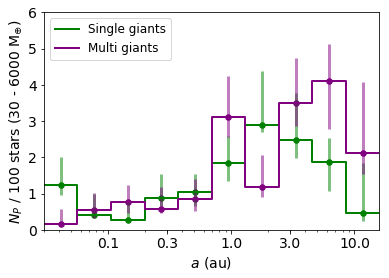

In [123]:
matplotlib.rcParams.update({'font.size': 14})
chains_db_single = pd.read_csv('occur_chains/occur_chains_giants_single_11x1.csv')
chains_db_multi  = pd.read_csv('occur_chains/occur_chains_giants_multi_11x1.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

a_chains = np.empty((0, len(chains_db_single)))
for n in np.arange(hierarchical_single.nbins):
    a_chains = np.append(a_chains, np.array([chains_db_single['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_single.bin_areas[0][0]*(100/719)

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_single.nbins):
    chains = np.array([chains_db_single['gamma{}'.format(n)]])*hierarchical_single.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)#/binwidth
a_159 = np.array(a_159)#/binwidth
a_841 = np.array(a_841)#/binwidth
a_682 = np.array(a_682)#/binwidth

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel(r'$N_P$ / 100 stars (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_xlim([np.exp(hierarchical_single.lna_edges[0]), np.exp(hierarchical_single.lna_edges[-1])])
ax.set_ylim([0, 10])
lnaw = hierarchical_single.lna_edges[1] - hierarchical_single.lna_edges[0]

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_single.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='green', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_single.lna_edges[:-1] + 0.5*lnaw), a_159,
          a_841, alpha=0.5, color='green', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_single.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_single.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='green', lw=2, label=r'Single giants')
 

a_chains_multi = np.empty((0, len(chains_db_multi)))
for n in np.arange(hierarchical_multi.nbins):
    a_chains_multi = np.append(a_chains_multi, np.array([chains_db_multi['gamma{}'.format(n)]]), axis=0)
a_chains_multi *= hierarchical_multi.bin_areas[0][0]*(100/719)

# Record modes & medians.
a_medians = np.median(a_chains_multi, axis=1)
a_sqvars  = np.std(a_chains_multi, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_multi.nbins):
    chains = np.array([chains_db_multi['gamma{}'.format(n)]])*hierarchical_multi.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)#/binwidth
a_159 = np.array(a_159)#/binwidth
a_841 = np.array(a_841)#/binwidth
a_682 = np.array(a_682)#/binwidth

#ax.set_xlim([np.exp(hierarchical_multi.lna_edges[0]), np.exp(hierarchical_multi.lna_edges[-1])])
ax.set_xlim([np.exp(hierarchical_multi.lna_edges[0]), 15.7])
ax.set_ylim([0, 6])
lnaw = hierarchical_multi.lna_edges[1] - hierarchical_multi.lna_edges[0]

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_multi.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='purple', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_multi.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='purple', lw=3, label='_nolegend_')
ax.vlines(np.exp(hierarchical_multi.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='purple', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_multi.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_multi.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='purple', lw=2, label=r'Multi giants')    
    
    
ax.legend(loc=2, fontsize=12) 
#fig.savefig('plots/single_and_multi_giants_axis.png', dpi=1000, bbox_inches='tight')
#fig.savefig('plots/single_and_multi_giants_axis.pdf', bbox_inches='tight')

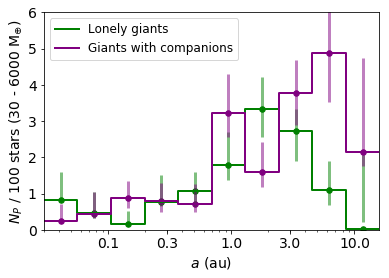

In [27]:
matplotlib.rcParams.update({'font.size': 14})
chains_db_single = pd.read_csv('occur_chains/occur_chains_giants_single_trend_11x1.csv')
chains_db_multi  = pd.read_csv('occur_chains/occur_chains_giants_multi_trend_11x1.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

a_chains = np.empty((0, len(chains_db_single)))
for n in np.arange(hierarchical_single.nbins):
    a_chains = np.append(a_chains, np.array([chains_db_single['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_single.bin_areas[0][0]*(100/719)

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_single.nbins):
    chains = np.array([chains_db_single['gamma{}'.format(n)]])*hierarchical_single.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)#/binwidth
a_159 = np.array(a_159)#/binwidth
a_841 = np.array(a_841)#/binwidth
a_682 = np.array(a_682)#/binwidth

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (au)')
ax.set_ylabel(r'$N_P$ / 100 stars (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_xlim([np.exp(hierarchical_single.lna_edges[0]), np.exp(hierarchical_single.lna_edges[-1])])
ax.set_ylim([0, 10])
lnaw = hierarchical_single.lna_edges[1] - hierarchical_single.lna_edges[0]

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_single.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='green', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_single.lna_edges[:-1] + 0.5*lnaw), a_159,
          a_841, alpha=0.5, color='green', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_single.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_single.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='green', lw=2, ls=':', label=r'Lonely giants')
 

a_chains_multi = np.empty((0, len(chains_db_multi)))
for n in np.arange(hierarchical_multi.nbins):
    a_chains_multi = np.append(a_chains_multi, np.array([chains_db_multi['gamma{}'.format(n)]]), axis=0)
a_chains_multi *= hierarchical_multi.bin_areas[0][0]*(100/719)

# Record modes & medians.
a_medians = np.median(a_chains_multi, axis=1)
a_sqvars  = np.std(a_chains_multi, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_multi.nbins):
    chains = np.array([chains_db_multi['gamma{}'.format(n)]])*hierarchical_multi.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)
a_159 = np.array(a_159)
a_841 = np.array(a_841)
a_682 = np.array(a_682)

#ax.set_xlim([np.exp(hierarchical_multi.lna_edges[0]), np.exp(hierarchical_multi.lna_edges[-1])])
ax.set_xlim([np.exp(hierarchical_multi.lna_edges[0]), 15.7])
ax.set_ylim([0, 6])
lnaw = hierarchical_multi.lna_edges[1] - hierarchical_multi.lna_edges[0]

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_multi.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='purple', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_multi.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='purple', lw=3, label='_nolegend_')
ax.vlines(np.exp(hierarchical_multi.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='purple', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_multi.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_multi.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='purple', lw=2, ls=':', label=r'Giants with companions')    
    
    
ax.legend(loc=2, fontsize=12) 
fig.savefig('plots/single_and_multi_giants_trends_axis.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/single_and_multi_giants_trends_axis.pdf', bbox_inches='tight')

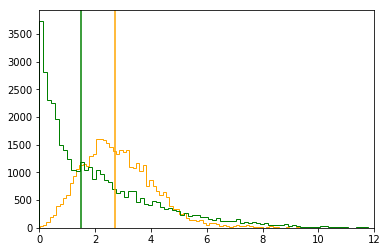

In [119]:
fig, ax = plt.subplots()
ax.set_xlim([0, 12])
ax.hist(a_chains[-2], bins=100, histtype='step', color='orange')
ax.hist(a_chains[-1], bins=100, histtype='step', color='green')
ax.axvline(np.median(a_chains[-2]), color='orange')
ax.axvline(np.median(a_chains[-1]), color='green')

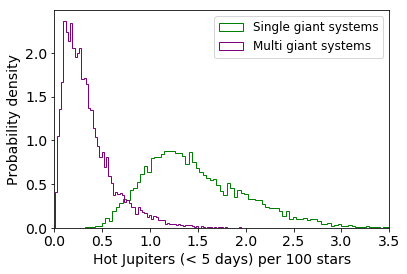

In [151]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.hist(a_chains[0], histtype='step', density=True, bins=100, color='green', label='Single giant systems')
ax.hist(a_chains_multi[0], histtype='step', density=True, bins=100, color='purple', label='Multi giant systems')
#ax.hist(a_chains[0] + a_chains_multi[0], histtype='step', density=True, bins=100, color='red', label='All')
#ax.axvline(np.percentile(a_chains[0] + a_chains_multi[0], 50), ls=':', color='red', label='Total median')
#ax.axvline(np.percentile(a_chains[0], 15.9), ls=':', color='green', label='15.9%')
#ax.axvline(np.percentile(a_chains_multi[0], 84.1), ls=':', color='purple', label='84.1%')
#ax.axvline(np.percentile(a_chains[0], 5), ls=':', color='green', label='__nolegend__')
#ax.axvline(np.percentile(a_chains_multi[0], 95), ls=':', color='purple', label='__nolegend__')

ax.set_xlim([0, 3.5])
ax.set_xlabel('Very hot Jupiters (< 0.06 au) per 100 stars')
ax.set_ylabel('Probability density')

ax.legend(fontsize=12)

In [52]:
warmbins = lngrid(0.1, 0.4, 30., 6000, 1, 1) 
hierarchical_single_warm = Hierarchy(samples_single, completey_all, bins=warmbins, lenrun=10000, 
                                    chainname='occur_chains/occur_chains_giants_single_warm.csv')
hierarchical_single_warm.max_like()
hierarchical_multi_warm = Hierarchy(samples_multi, completey_all, bins=warmbins, lenrun=10000,
                                   chainname='occur_chains/occur_chains_giants_single_warm.csv')
hierarchical_multi_warm.max_like()

In [53]:
hierarchical_single_warm.sample(parallel=True, gp=False)
hierarchical_multi_warm.sample(parallel=True, gp=False)

100%|██████████| 10000/10000 [21:55<00:00,  7.60it/s]


In [56]:
warm_single = hierarchical_single_warm.chains*hierarchical_single_warm.bin_areas[0][0]*(100/719)
warm_multi = hierarchical_multi_warm.chains*hierarchical_multi_warm.bin_areas[0][0]*(100/719)

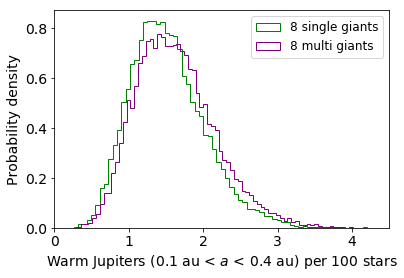

In [22]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.hist(warm_single, histtype='step', density=True, bins=75, color='green', 
        label='{} single giants'.format(len(giants_single.query('axis>=0.1 and axis<0.4'))))
ax.hist(warm_multi, histtype='step', density=True, bins=75, color='purple', 
        label='{} multi giants'.format(len(giants_multi.query('axis>=0.1 and axis<0.4'))))

ax.set_xlim([0, 4.5])
ax.set_xlabel(r'Warm Jupiters (0.1 au < $a$ < 0.4 au) per 100 stars')
ax.set_ylabel('Probability density')

ax.legend(fontsize=12)

fig.savefig('plots/single_multi_warm.pdf', bbox_inches='tight')

In [14]:
hotbins = lngrid(0.06, 0.1, 30., 6000, 1, 1) 
hierarchical_single_hot = Hierarchy(samples_single, completey_all, bins=hotbins, lenrun=10000,
                                    chainname='occur_chains/occur_chains_giants_single_hot.csv')
hierarchical_single_hot.max_like()
hierarchical_multi_hot = Hierarchy(samples_multi, completey_all, bins=hotbins, lenrun=10000,
                                   chainname='occur_chains/occur_chains_giants_single_hot.csv')
hierarchical_multi_hot.max_like()

In [15]:
hierarchical_single_hot.sample(parallel=True, gp=False)
hierarchical_multi_hot.sample(parallel=True, gp=False)

  3%|▎         | 278/10000 [00:23<14:14, 11.37it/s]Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/Academics/Astronomy/Planets/CLSIV/occur.py", line 249, in lnpost
    return self.lnlike(theta)
  File "/Users/lee/Academics/Astronomy/Planets/CLSIV/occur.py", line 228, in lnlike
    np.log(sample_a), np.log(sample_M), theta)
  File "/Users/lee/Academics/Astronomy/Planets/CLSIV/occur.py", line 205, in occurrence
    im[im > self.nmbins - 1] = self.nmbins - 1
KeyboardInterrupt
  3%|▎         | 279/10000 [00:23<13:30, 12.00it/s]Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceb

emcee: Exception while calling your likelihood function:
  params: [0.76243297]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [15]:
hot_single = hierarchical_single_hot.chains*hierarchical_single_hot.bin_areas[0][0]*(100/719)
hot_multi = hierarchical_multi_hot.chains*hierarchical_multi_hot.bin_areas[0][0]*(100/719)

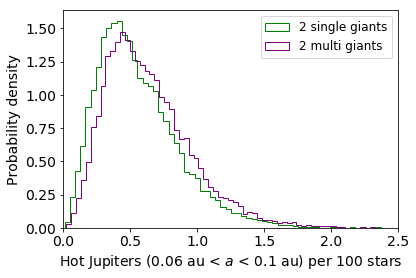

In [18]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.hist(hot_single, histtype='step', density=True, bins=75, color='green', 
        label='{} single giants'.format(len(giants_single.query('axis>=0.06 and axis<0.1'))))
ax.hist(hot_multi, histtype='step', density=True, bins=75, color='purple', 
        label='{} multi giants'.format(len(giants_multi.query('axis>=0.06 and axis<0.1'))))
#ax.hist(a_chains[0] + a_chains_multi[0], histtype='step', density=True, bins=100, color='red', label='All')
#ax.axvline(np.percentile(a_chains[0] + a_chains_multi[0], 50), ls=':', color='red', label='Total median')
#ax.axvline(np.percentile(a_chains[0], 15.9), ls=':', color='green', label='15.9%')
#ax.axvline(np.percentile(a_chains_multi[0], 84.1), ls=':', color='purple', label='84.1%')
#ax.axvline(np.percentile(a_chains[0], 5), ls=':', color='green', label='__nolegend__')
#ax.axvline(np.percentile(a_chains_multi[0], 95), ls=':', color='purple', label='__nolegend__')

ax.set_xlim([0, 2.5])
ax.set_xlabel(r'Hot Jupiters (0.06 au < $a$ < 0.1 au) per 100 stars')
ax.set_ylabel('Probability density')

ax.legend(fontsize=12)

fig.savefig('plots/single_multi_hot.pdf', bbox_inches='tight')

In [13]:
shotbins = lngrid(0.03, 0.06, 30., 6000, 1, 1) 
hierarchical_single_superhot = Hierarchy(samples_single, completey_all, bins=shotbins, lenrun=10000,
                                    chainname='occur_chains/occur_chains_giants_single_shot.csv')
                                    #chainname='occur_chains/occur_chains_giants_single_trend_shot.csv')
hierarchical_single_superhot.max_like()
hierarchical_multi_superhot = Hierarchy(samples_multi, completey_all, bins=shotbins, lenrun=10000,
                                   chainname='occur_chains/occur_chains_giants_multi_shot.csv')
                                   #chainname='occur_chains/occur_chains_giants_multi_trend_shot.csv')
hierarchical_multi_superhot.max_like()

In [14]:
hierarchical_single_superhot.sample(parallel=True, gp=False)
hierarchical_multi_superhot.sample(parallel=True, gp=False)

100%|██████████| 10000/10000 [13:47<00:00, 12.08it/s]


In [15]:
shot_single = hierarchical_single_superhot.chains*hierarchical_single_superhot.bin_areas[0][0]*(100/719)
shot_multi = hierarchical_multi_superhot.chains*hierarchical_multi_superhot.bin_areas[0][0]*(100/719)

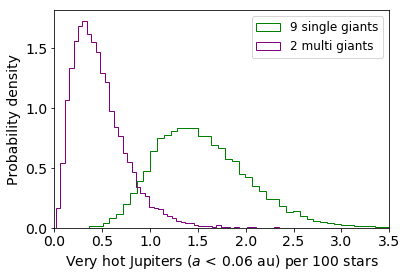

In [17]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.hist(shot_single, histtype='step', density=True, bins=50, color='green',
        label='{} single giants'.format(len(giants_single.query('axis>=0.03 and axis<0.06'))))
ax.hist(shot_multi, histtype='step', density=True, bins=50, color='purple',
        label='{} multi giants'.format(len(giants_multi.query('axis>=0.03 and axis<0.06'))))

ax.set_xlim([0, 3.5])
ax.set_xlabel(r'Very hot Jupiters ($a$ < 0.06 au) per 100 stars')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_superhot.pdf', bbox_inches='tight')

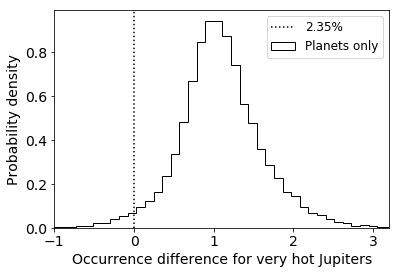

In [21]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

#shot_single_load = pd.read_csv('occur_chains/occur_chains_giants_single_shot.csv').gamma0
#shot_multi_load  = pd.read_csv('occur_chains/occur_chains_giants_multi_shot.csv').gamma0

diff = shot_single - shot_multi
percentile = np.round(scipy.stats.percentileofscore(diff, 0), 2)

ax.hist(diff, histtype='step', density=True, bins=50, 
        color='black', label='Planets only')

ax.axvline(0, ls=':', color='black', 
           label='{}%'.format(percentile))

ax.set_xlim([-1, 3.2])
ax.set_xlabel('Occurrence difference for very hot Jupiters')
ax.set_ylabel('Probability density')

ax.legend(fontsize=12)

fig.savefig('plots/difference_superhot.pdf', bbox_inches='tight')

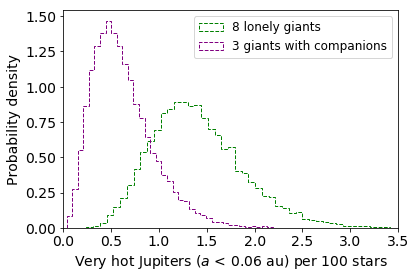

In [32]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.hist(shot_single, histtype='step', density=True, bins=50, ls='--', color='green',
        label='{} lonely giants'.format(len(giants_single_trend.query('axis>=0.03 and axis<0.06'))))
ax.hist(shot_multi, histtype='step', density=True, bins=50, ls='--', color='purple',
        label='{} giants with companions'.format(len(giants_multi_trend.query('axis>=0.03 and axis<0.06'))))

ax.set_xlim([0, 3.5])
ax.set_xlabel(r'Very hot Jupiters ($a$ < 0.06 au) per 100 stars')
ax.set_ylabel('Probability density')

ax.legend(fontsize=12)

fig.savefig('plots/single_multi_trend_superhot.pdf', bbox_inches='tight')

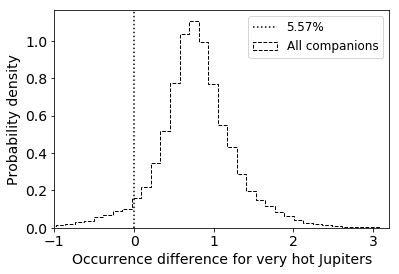

In [37]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

diff = shot_single - shot_multi
percentile = np.round(scipy.stats.percentileofscore(diff, 0), 2)

ax.hist(diff, histtype='step', density=True, bins=50, 
        color='black', ls='--', label='All companions')

ax.axvline(0, ls=':', color='black', 
           label='{}%'.format(percentile))

ax.set_xlim([-1, 3.2])
ax.set_xlabel('Occurrence difference for very hot Jupiters')
ax.set_ylabel('Probability density')

ax.legend(fontsize=12)

fig.savefig('plots/difference_trend_superhot.pdf', bbox_inches='tight')

## Compute Laughlin number.

In [10]:
gregbins = lngrid(3, 6, 0.3*317.8, 3*317.8, 1, 1) 
hierarchical_greg = Hierarchy(samples_all, completey_all, bins=gregbins, lenrun=10000, 
                                    chainname='occur_chains/occur_chains_greg.csv')
hierarchical_greg.max_like()

In [11]:
hierarchical_greg.sample(parallel=True, gp=False)

100%|██████████| 10000/10000 [29:48<00:00,  5.59it/s]


In [12]:
greg = hierarchical_greg.chains*hierarchical_greg.bin_areas[0][0]*(100/719)


In [13]:
print(np.median(greg), '+/-', 0.5*(np.percentile(greg, 84.1) - \
                                   np.percentile(greg, 15.9)))

6.285917889917593 +/- 1.3708811704140706


In [16]:
juppys = planets.query('mass >= 0.3 and mass < 3 and axis >= 3 and axis < 6')

In [17]:
juppys

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
8,15,114783,K,2.0,0.653665,0.659320,0.613194,0.705603,4.950489,4.969085,...,0.141665,0.017871,0.017709,0.016291,0.019186,1.768966,1.773011,0.016291,0.019186,/data/user/lrosenth/legacy/final_run/114783/11...
12,20,117207,K,1.0,1.872094,1.869543,1.795250,1.946500,3.743901,3.744161,...,0.154149,0.082141,0.082129,0.075007,0.089695,1.208147,1.208189,0.075007,0.089695,/data/user/lrosenth/legacy/final_run/117207/11...
13,21,11964a,K,1.0,0.635083,0.630694,0.603547,0.658001,3.185356,3.185235,...,0.122298,0.302698,0.302502,0.275326,0.332116,0.871982,0.872122,0.275326,0.332116,/data/user/lrosenth/legacy/final_run/11964a/11...
26,40,136925,C,1.0,0.872652,0.840422,0.766177,0.918395,5.209309,5.130608,...,0.146360,0.052280,0.053853,0.049808,0.058131,1.352622,1.342632,0.049808,0.058131,/data/user/lrosenth/legacy/final_run/136925/13...
27,42,13931,K,1.0,1.918693,1.910991,1.835257,1.987931,5.320475,5.322523,...,0.028891,0.061009,0.060953,0.055720,0.066532,1.301401,1.301698,0.055720,0.066532,/data/user/lrosenth/legacy/final_run/13931/139...
32,49,141399,K,4.0,0.651577,0.643977,0.603644,0.685634,4.514038,4.495975,...,0.069640,0.083021,0.083678,0.076429,0.091589,1.204933,1.202559,0.076429,0.091589,/data/user/lrosenth/legacy/final_run/141399/14...
37,60,145934,K,1.0,2.069045,2.039347,1.809421,2.279885,4.723628,4.729761,...,0.082606,1.045723,1.043213,0.928609,1.179259,0.639595,0.639980,0.928609,1.179259,/data/user/lrosenth/legacy/final_run/145934/14...
41,69,154345,K,2.0,0.923215,0.905009,0.815812,0.976007,4.256815,4.271967,...,0.054298,0.034064,0.033736,0.030930,0.036664,1.505516,1.509161,0.030930,0.036664,/data/user/lrosenth/legacy/final_run/154345/15...
66,108,187123,K,2.0,1.714340,1.712769,1.655453,1.770979,4.430876,4.432013,...,0.235218,0.067383,0.067345,0.061688,0.073470,1.269469,1.269647,0.061688,0.073470,/data/user/lrosenth/legacy/final_run/187123/18...
69,112,190360,K,1.0,1.491530,1.492034,1.449298,1.534622,3.954768,3.955002,...,0.331251,0.073294,0.073273,0.067685,0.079374,1.243060,1.243151,0.067685,0.079374,/data/user/lrosenth/legacy/final_run/190360/19...


In [18]:
len(juppys)*100/719

2.642559109874826